# BTC breakout strategy using VWAP

- Backtest on Binance dataset

# Set up

Set up Trading Strategy data client.


In [24]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [25]:
from tradingstrategy.chain import ChainId
import datetime

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "binance-btc-breakout-vwap-2" # Used in cache paths

    cycle_duration = CycleDuration.cycle_1d
    candle_time_bucket = TimeBucket.d1
    allocation = 0.98

    adx_length = 30
    adx_filter_threshold = 0

    trailing_stop_loss_pct = 0.98
    trailing_stop_loss_activation_level = 1.075
    stop_loss_pct = 0.98
    take_profit_pct = 1.10

    #
    # Live trading only
    #
    chain_id = ChainId.polygon
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = datetime.timedelta(hours=200)

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 10, 1)
    backtest_end = datetime.datetime(2024, 5, 1)
    backtest_trading_fee = 0.0005
    stop_loss_time_bucket = TimeBucket.m15
    initial_cash = 10_000

    backtest_source = "eth"

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Binance CEX data so we have longer history to backtest

In [26]:
from tradingstrategy.client import Client
from tradingstrategy.lending import LendingProtocolType

from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions

def get_trading_pairs(backtest_source):
    # List of trading pairs we use in the backtest
    if backtest_source == "binance":
        trading_pairs = [
            (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
        ]
    elif backtest_source == "eth":
        trading_pairs = [
            (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0005),
        ]
    elif backtest_source == "arb":
        trading_pairs = [
            (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0005),
        ]
    else:
        raise NotImplementedError(f"Does not know: {backtest_source}")

    return trading_pairs


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - For live trading, we load DEX data
    """

    trading_pairs = get_trading_pairs(Parameters.backtest_source)
    
    if Parameters.backtest_source == "binance":
        strategy_universe = create_binance_universe(
            [f"{p[2]}{p[3]}" for p in trading_pairs],
            candle_time_bucket=Parameters.candle_time_bucket,
            stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
            start_at=universe_options.start_at,
            end_at=universe_options.end_at,
            trading_fee_override=Parameters.backtest_trading_fee,
        )
    else:
        dataset = load_partial_data(
            client=client,
            time_bucket=Parameters.candle_time_bucket,
            pairs=trading_pairs,
            execution_context=execution_context,
            universe_options=universe_options,
            liquidity=False,
            stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
            start_at=universe_options.start_at,
            end_at=universe_options.end_at,
        )        

        # to the strategy and indicators
        strategy_universe = TradingStrategyUniverse.create_from_dataset(
            dataset,
            reserve_asset="USDC",
            forward_fill=True,
        )
    return strategy_universe

strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk

In [27]:
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource, IndicatorDependencyResolver
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def regime(
    open, 
    high, low, close, length, regime_threshold,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """
    # def regime_filter(row):
    #     # ADX, DMP, # DMN
    #     average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values
    #     if directional_momentum_positive > regime_threshold:
    #         return Regime.bull.value
    #     elif directional_momentum_negative > regime_threshold:
    #         return Regime.bear.value
    #     else:
    #         return Regime.crab.value

    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values

        # We use a threshold to eliminate the noise in ADX,
        # but the threshold can be also zero
        if average_direction_index > regime_threshold:
            # In this case the filter is that if ADX positive is higher than ADX negative,
            # we bullish
            if directional_momentum_positive > directional_momentum_negative:
                return Regime.bull.value
            else:
                return Regime.bear.value
        else:
            return Regime.crab.value

    # regime_signal = adx_df.apply(regime_filter, axis="columns")
    adx_df = dependency_resolver.get_indicator_data(
        "adx",
        parameters={"length": length},
        column="all",
    )
    # adx_df = pandas_ta.adx(high=high, low=low, close=close, length=length)
    regime_signal = adx_df.apply(regime_filter, axis="columns")    
    return regime_signal



def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/overlap/vwap.py
    indicators.add(
        "vwap",
        pandas_ta.vwap,
        {},
        IndicatorSource.ohlcv,
    )

    # ADX https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp
    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/adx.py
    indicators.add(
        "adx",
        pandas_ta.adx,
        {"length": parameters.adx_length},
        IndicatorSource.ohlcv,
        order=1,
    )

    # Price OHLC resampled to daily
    # indicators.add(
    #     "daily_price",
    #     daily_price,
    #     {},
    #     IndicatorSource.ohlcv,
    # )

    # A regime filter to detect the trading pair bear/bull markets
    indicators.add(
        "regime",
        regime,
        {"length": parameters.adx_length, "regime_threshold": parameters.adx_filter_threshold},
        IndicatorSource.ohlcv,
        order=2,
    )
        
    return indicators


# Trading algorithm

- Describe out trading strategy as code

In [28]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    trading_pairs = get_trading_pairs(Parameters.backtest_source)
    pair = strategy_universe.get_single_pair()
    cash = position_manager.get_current_cash()

    #
    # Indicators
    #

    close_price = indicators.get_price()  # Price the previous 15m candle closed for this decision cycle timestamp
    vwap = indicators.get_indicator_value("vwap")
    regime_val = indicators.get_indicator_value("regime")  # Because the regime filter is calculated only daily, we allow some lookback
 
    if None in (vwap, close_price):
        # Not enough historic data,
        # cannot make decisions yet
        return []
    
    # If regime filter does not have enough data at the start of the backtest, default to crab market
    if regime_val is None:
        regime = Regime.crab
    else:
        regime = Regime(regime_val)  # Convert to enum for readability
        
    #
    # Trading logic
    #

    trades = []

    # Check for open condition - is the price breaking out
    #
    if not position_manager.is_any_open():
        if regime == Regime.bull:
            if close_price > vwap:
                # print(f"Opening position at {timestamp} since regime_val is {regime_val}")
                # print(indicators.get_indicator_value("daily_price", column="timestamp"))
                # print(indicators.get_indicator_value("daily_price", column="close"))
                # print("Regime series:", indicators.resolve_indicator_data("regime"))

                # print(indicators.get_indicator_value("adx"))
                trades += position_manager.open_spot(
                    pair,
                    value=cash * parameters.allocation,
                    stop_loss_pct=parameters.stop_loss_pct,             
                )
    else:        
        # Enable trailing stop loss after we reach the profit taking level
        #
        for position in state.portfolio.open_positions.values():
            if position.trailing_stop_loss_pct is None:
                close_price = indicators.get_price(position.pair)
                if close_price >= position.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                    position.trailing_stop_loss_pct = parameters.trailing_stop_loss_pct                

    # Visualisations
    #
    if input.is_visualisation_enabled():
        visualisation = state.visualisation
        visualisation.plot_indicator(timestamp, "VWAP", PlotKind.technical_indicator_on_price, vwap)

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [29]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    strategy_logging=False,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators vwap, adx, regime for 1 pairs, using 8 threads:   0%|          | 0/3 [00:00<?, ?it/s…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1d_WBTC-USDC_2022-10-01-2024-05-01_ff


  0%|          | 0/49939200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 184 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against MATIC buy and hold

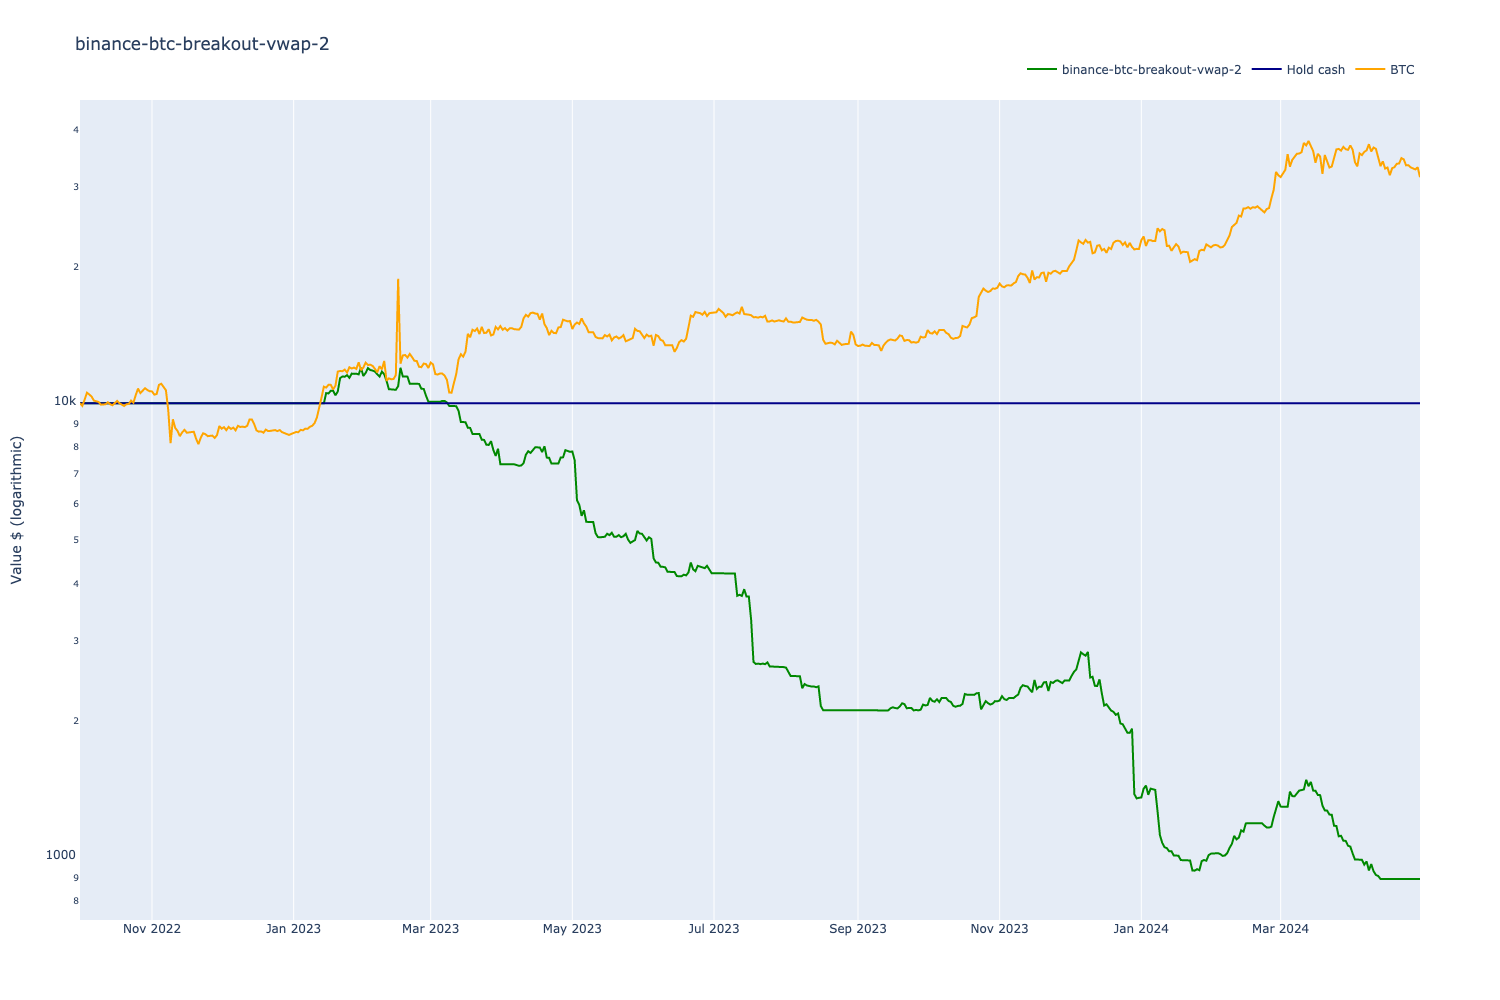

In [30]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash()
)

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Technical indicator and trade visualisation

- Draw the technical indicators we filled in in `decide_trades()`
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study.
  However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

In [31]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_single_pair(
    state,
    execution_context=notebook_execution_context,
    candle_universe=strategy_universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show(renderer="vscode")

# Volume visualisation

- Visualise the shape of the trade volumne

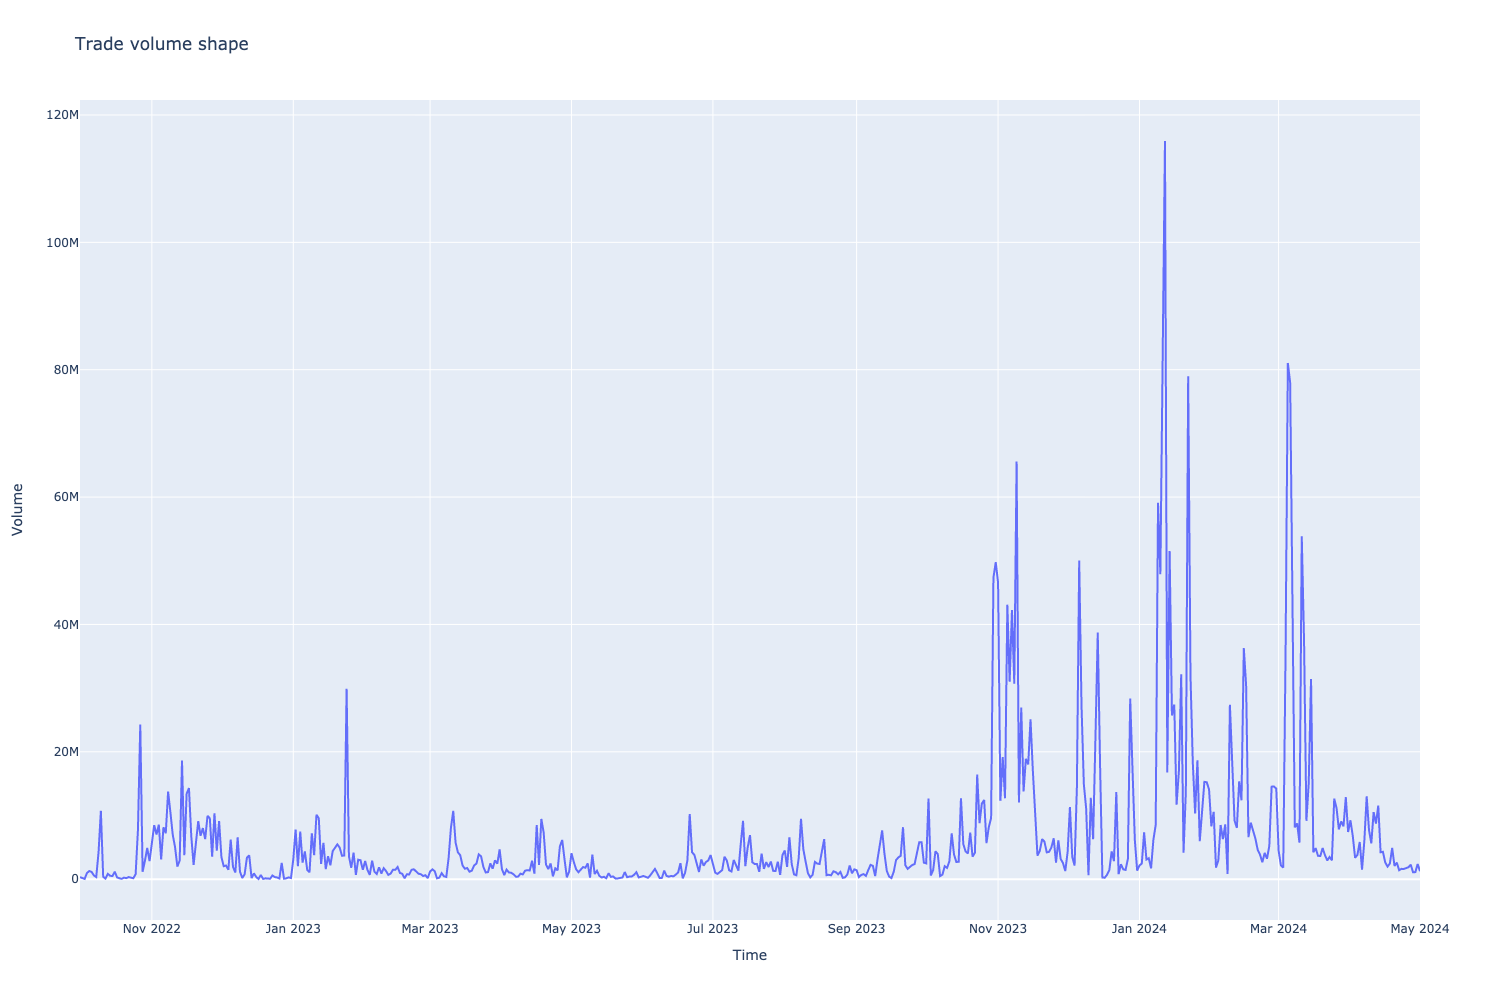

In [32]:
import plotly.express as px

pairs = get_trading_pairs(Parameters.backtest_source)
pair = pairs[0]

# Pull the pair and its close price we are detecting regimes for
indicators = result.indicators

# daily_price = indicators.get_indicator_dataframe("daily_price", pair=trading_pairs[0])
# daily_price = indicators.get_price_series()
volume = indicators.get_price_series("volume")


fig = px.line(volume, title='Trade volume shape')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Volume")
fig.update_xaxes(title="Time")
fig.show()


# Regime filter visualisation 

- Visualise the regime filter to show how well our bear/bull market flagging works


In [33]:
# Pull the pair and its close price we are detecting regimes for
indicators = result.indicators
# daily_price = indicators.get_indicator_dataframe("daily_price", pair=trading_pairs[0])
# daily_price = indicators.get_price_series()
close_price = indicators.get_price_series()

Lay out the regime filter signal on the top of price chart.

- Green: bull market regime detected
- Red: bear market regime detected
- No background colour: sideways (crab) market detected

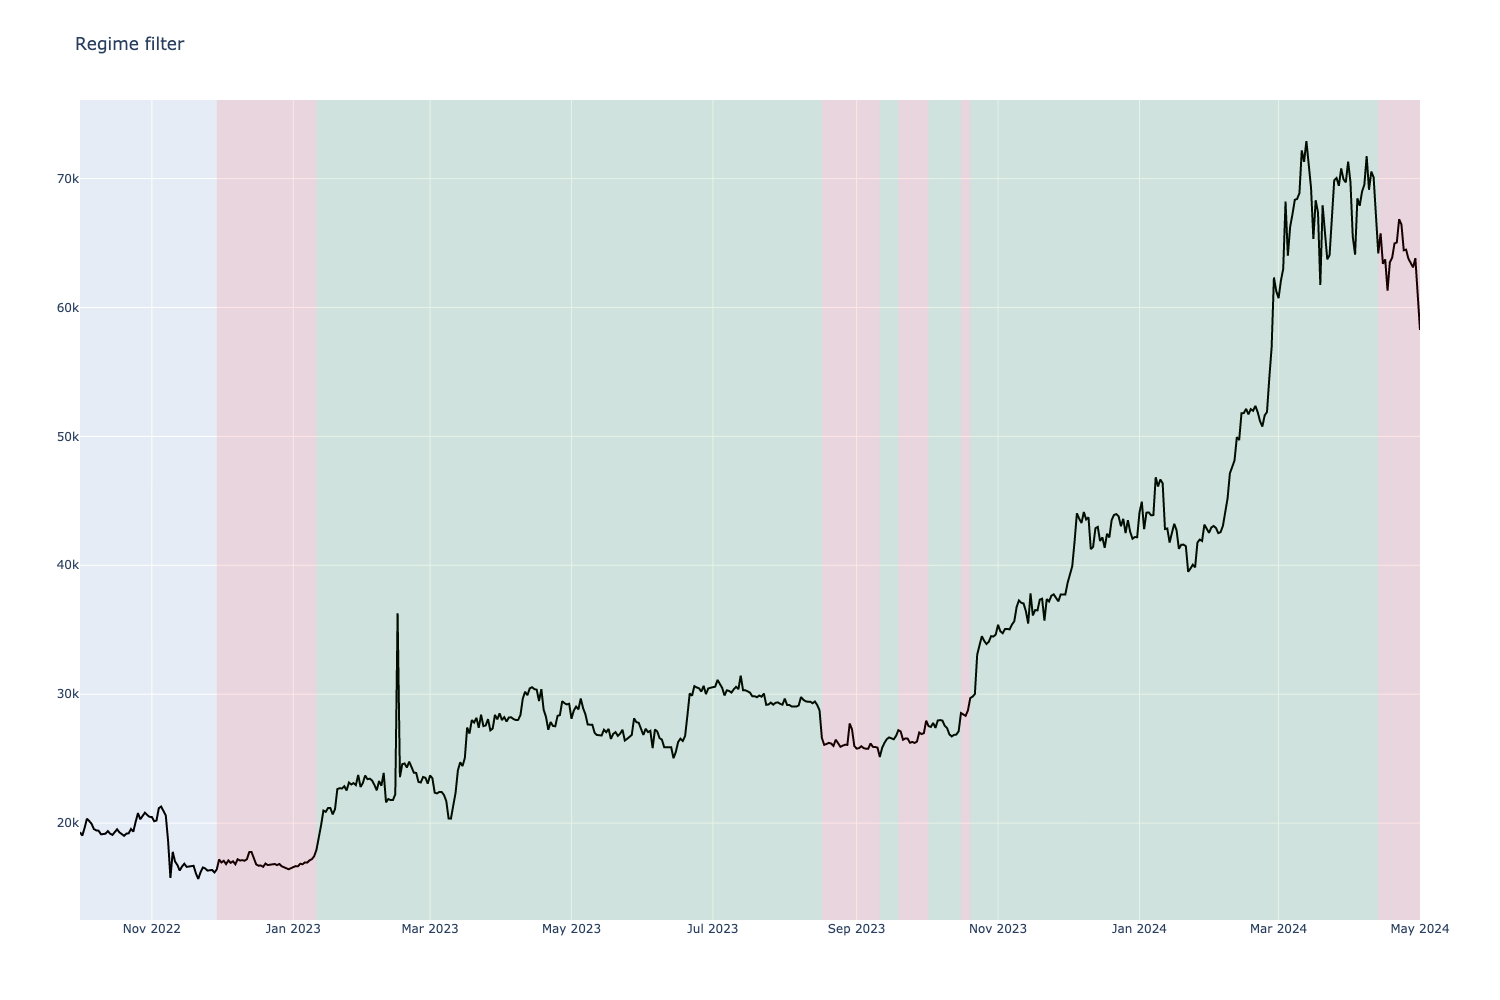

In [34]:
from tradeexecutor.visual.bullbear import visualise_market_regime_filter

trading_pairs = get_trading_pairs(Parameters.backtest_source)

regime_signal = result.indicators.get_indicator_series("regime", pair=trading_pairs[0], unlimited=True)
visualise_market_regime_filter(
    close_price,
    regime_signal,
)

Visualise raw ADX data so we have an idea what are good threshold levels for the regime filtering.

 - ADX = [Average Directional Index](https://www.investopedia.com/terms/a/adx.asp)
 - DMP = Directional Movement Positive
 - DMN = Directional Movement Negative

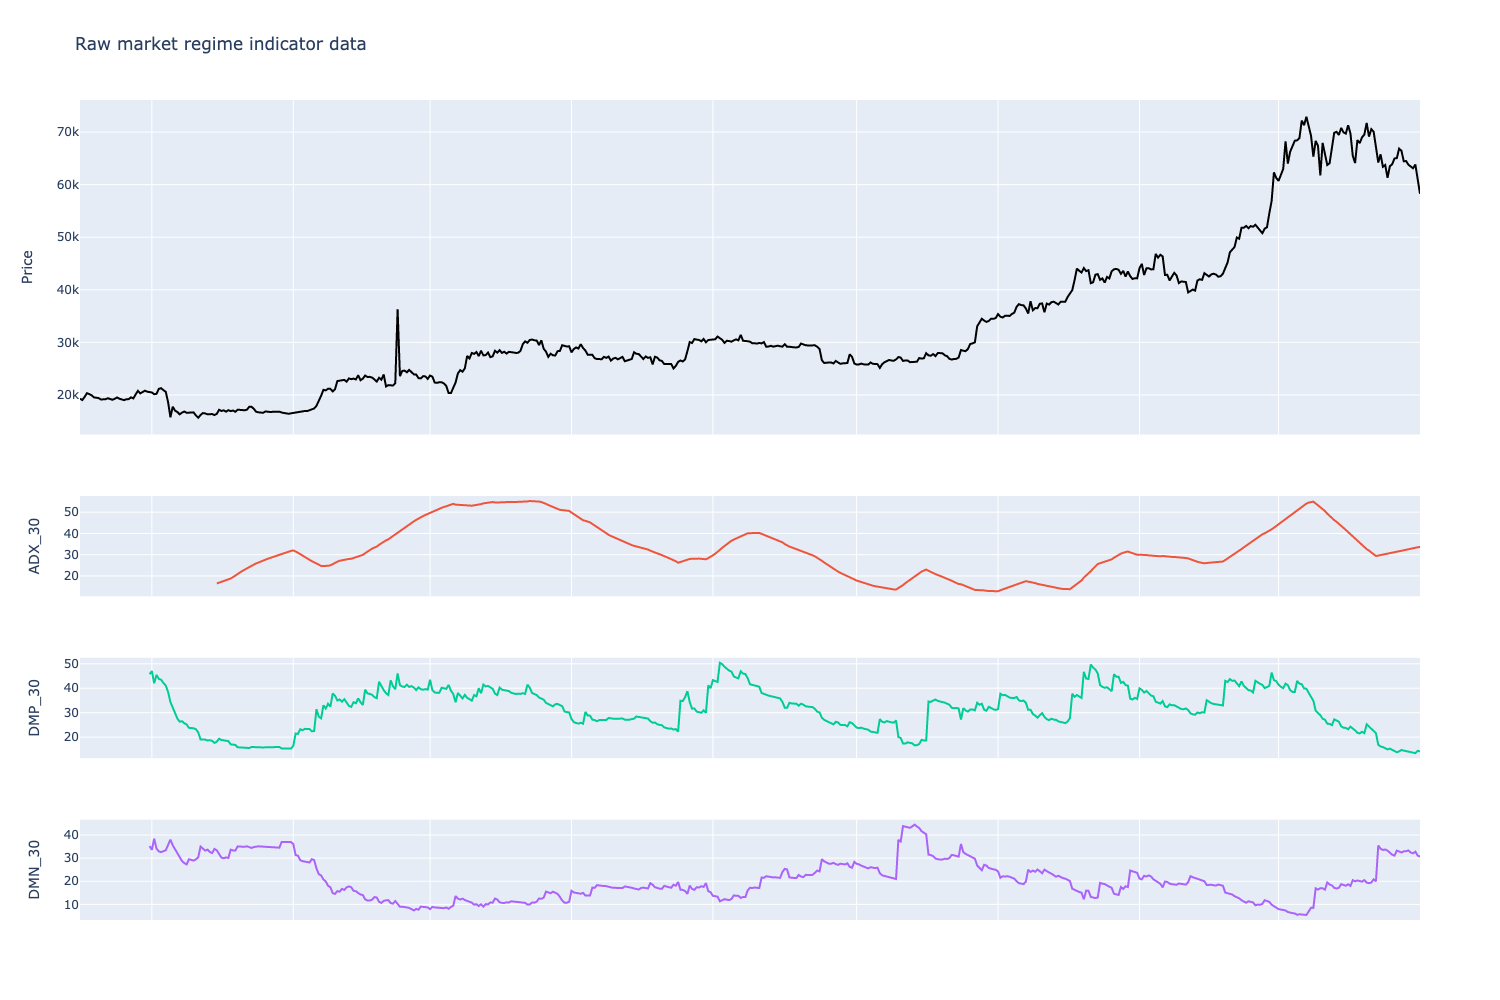

In [35]:
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

adx_df = result.indicators.get_indicator_dataframe("adx")
visualise_raw_market_regime_indicator(
    close_price, 
    adx_df,
    height=500,
    indicator_height=150,
)


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

In [36]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

Strategy         BTC
Start Period             2022-10-01  2022-10-01
End Period               2024-04-30  2024-04-30
Risk-Free Rate                 0.0%        0.0%
Time in Market                66.0%      100.0%
Cumulative Return           -91.05%     214.57%
CAGR﹪                       -78.28%     106.47%
Sharpe                        -2.64         1.3
Prob. Sharpe Ratio             0.0%      97.09%
Sortino                       -2.94        2.33
Sortino/√2                    -2.08        1.65
Omega                          0.55        0.55
Max Drawdown                -92.52%      -43.9%
Longest DD Days                 438         266
Gain/Pain Ratio               -0.45        0.33
Gain/Pain (1M)                -0.77        2.86
Payoff Ratio                   0.86         1.8
Profit Factor                  0.55        1.33
Common Sense Ratio             0.39        1.74
CPC Index                      0.18        1.23
Tail Ratio                     0.72        1.31
Outlier Win Ratio              6.84        3.28
Outlier Loss Ratio             5.26        5.48
MTD                         -15.15%      -14.9%
3M                           -8.86%      40.62%
6M                          -58.92%      75.89%
YTD                         -33.77%      43.89%
1Y                          -88.58%     107.77%
3Y (ann.)                   -78.28%     106.47%
5Y (ann.)                   -78.28%     106.47%
10Y (ann.)                  -78.28%     106.47%
All-time (ann.)             -78.28%     106.47%
Avg. Drawdown               -13.43%      -7.12%
Avg. Drawdown Days               58          22
Recovery Factor               -0.98        4.89
Ulcer Index                    0.65        0.18
Serenity Index                -0.03        1.42
Annualised return (raw)    -0.78277         NaN

# Trading statistics

- Display summare about made trades

In [37]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Rolling Sharpe

- See how the six months rolling Sharpe ratio changes over time

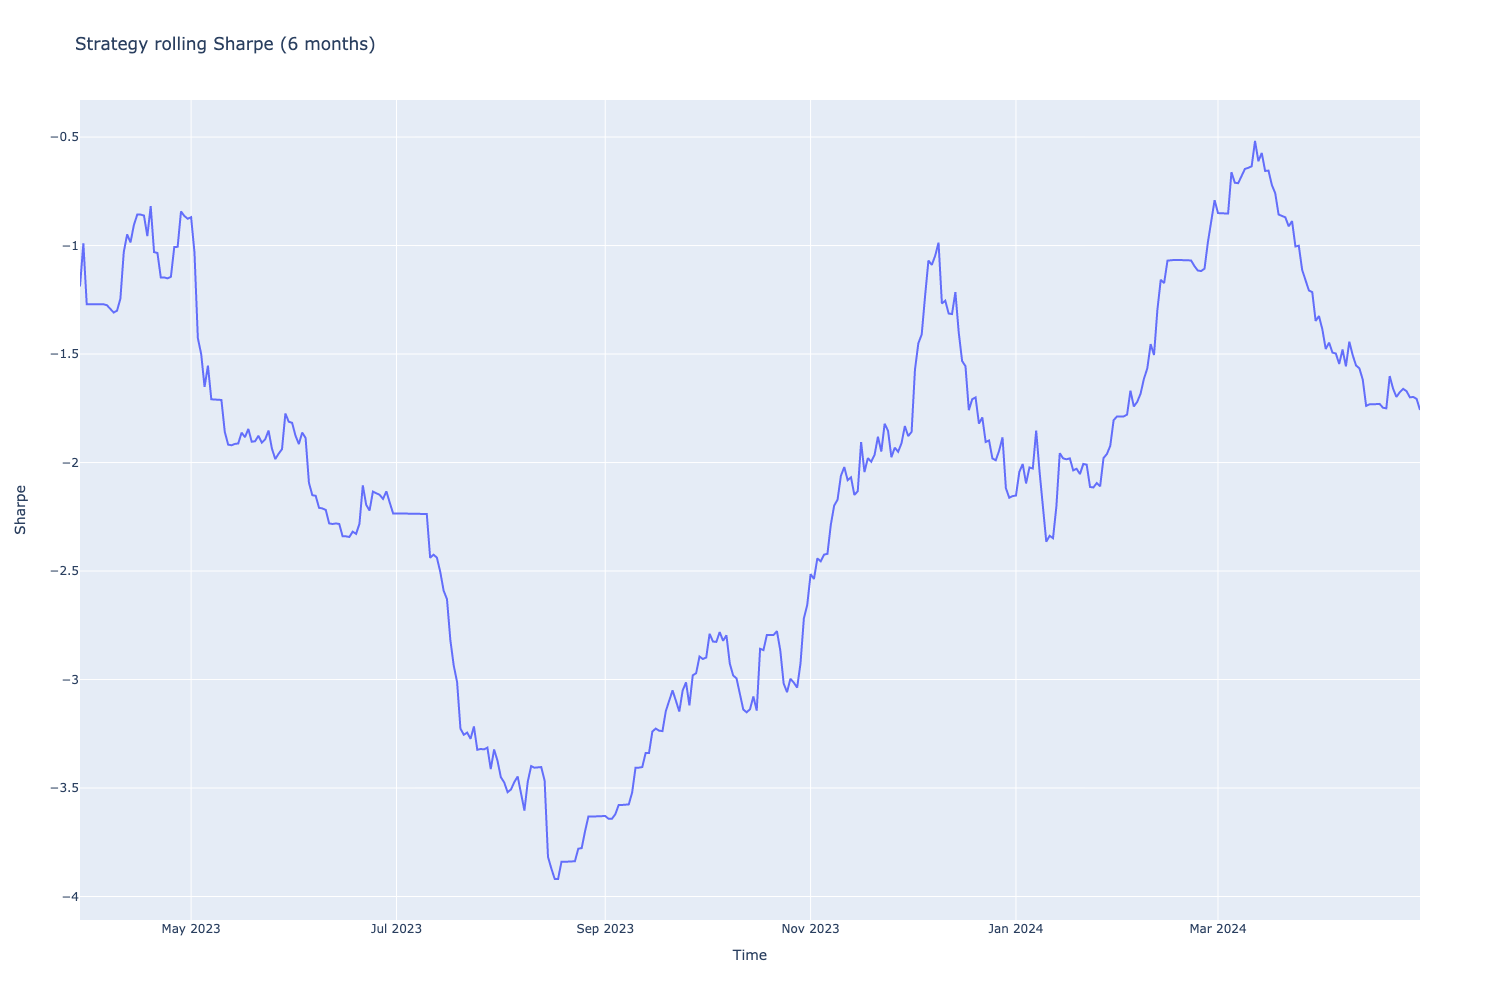

In [38]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()

# Weekday and hour profitability

Draw wall clock and weekday heatmap to determine if some days or hours are better to open position than others.

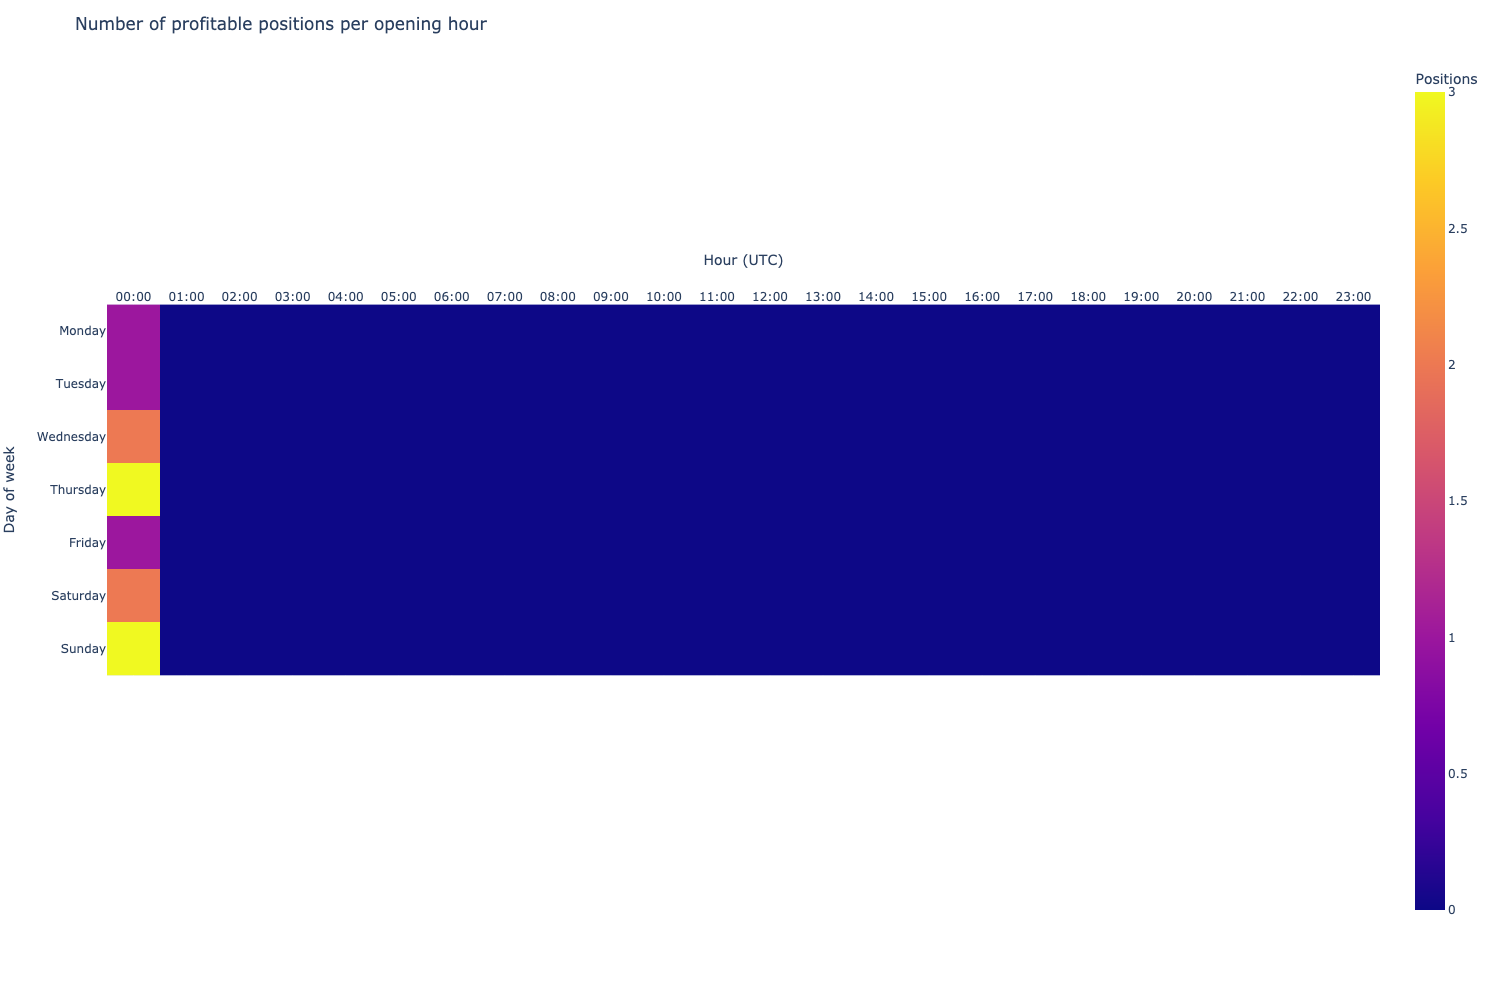

In [39]:
from tradeexecutor.analysis.timemap import ScoringMethod, visualise_weekly_time_heatmap

visualise_weekly_time_heatmap(
    state.portfolio.get_all_positions(),
    ScoringMethod.success_rate,
)

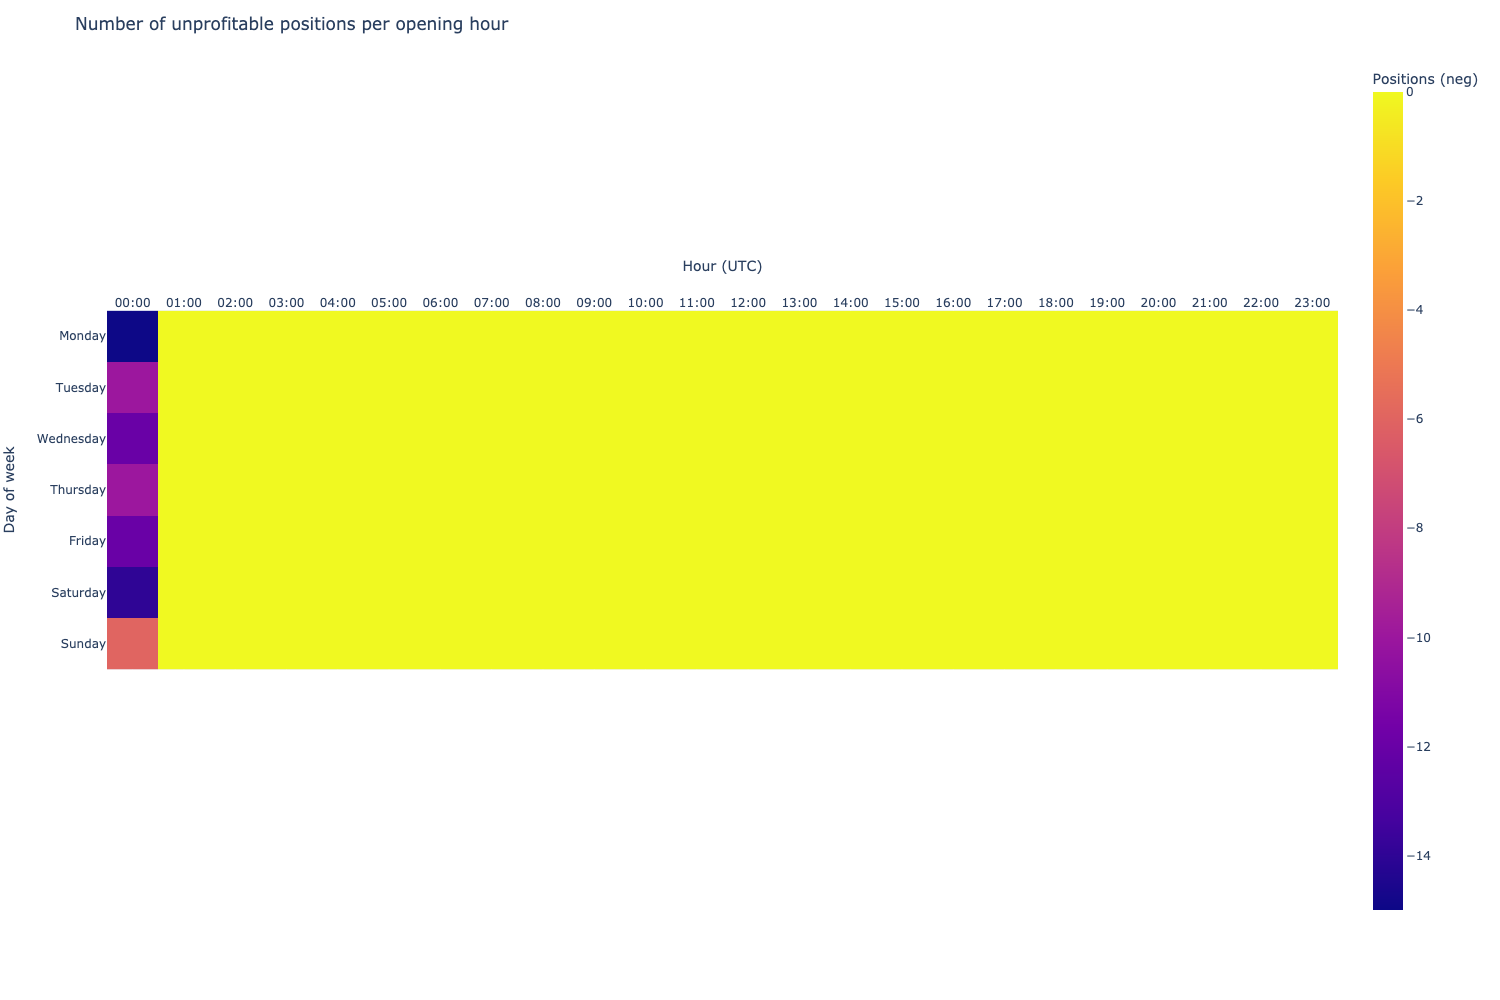

In [40]:

visualise_weekly_time_heatmap(
    state.portfolio.get_all_positions(),
    ScoringMethod.failure_rate,
)

[[-61.60922288239101, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-31.81744203465206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-33.44092903811065, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-6.797638932452401, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-29.452448008212556, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-30.980579365089227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7.239670466282021, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


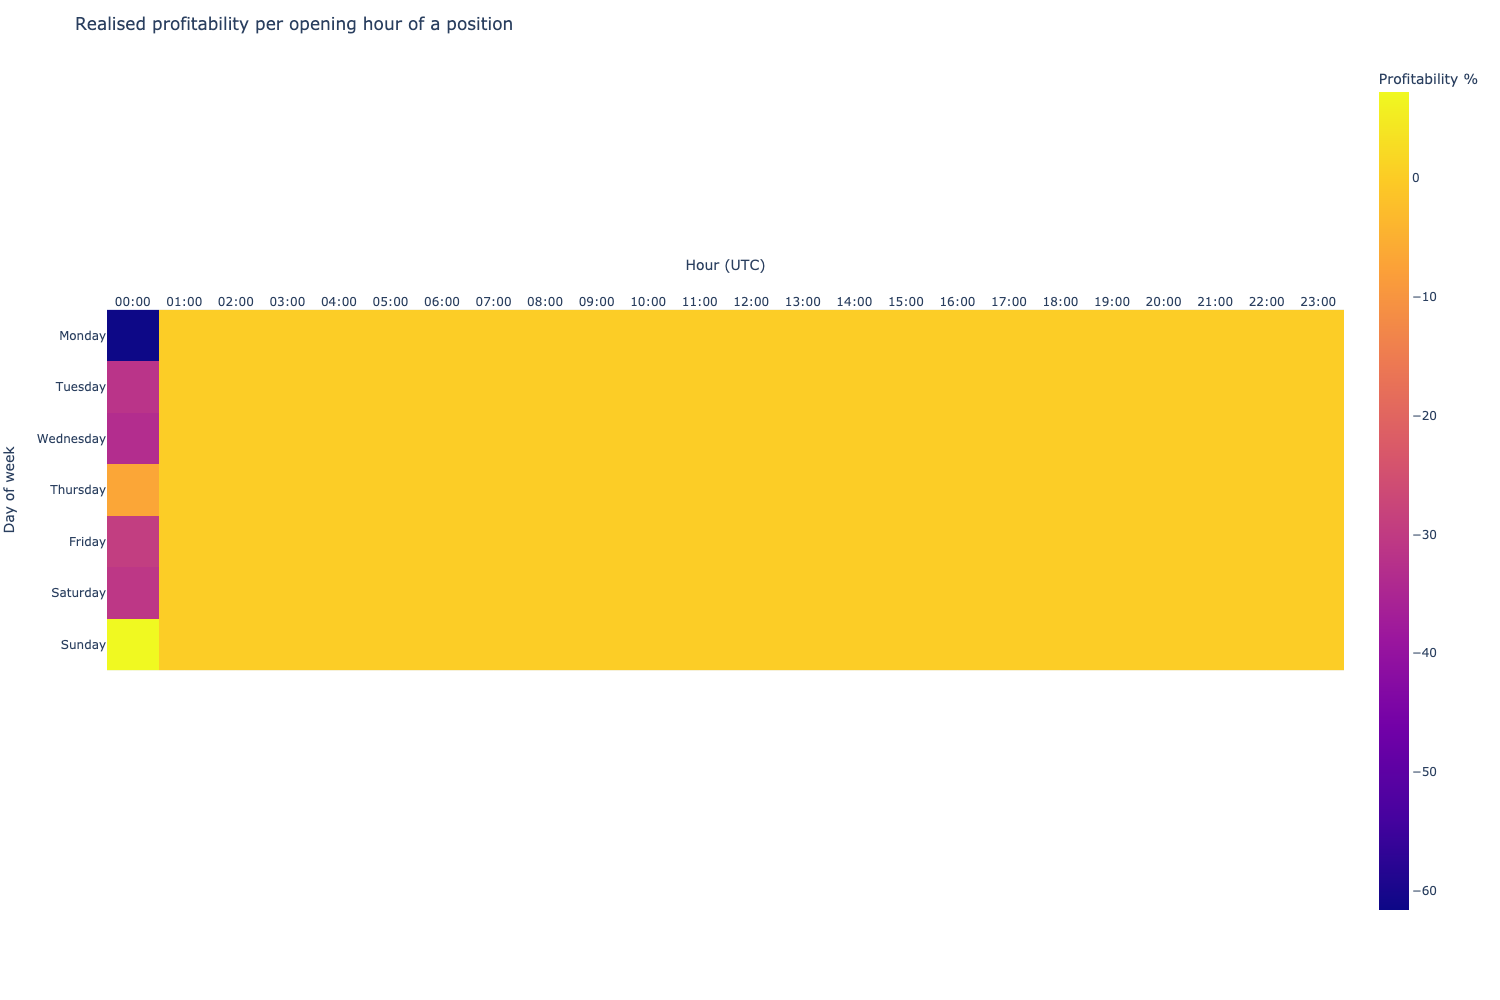

In [41]:

visualise_weekly_time_heatmap(
    state.portfolio.get_all_positions(),
    ScoringMethod.realised_profitability,
)